# Homework 2: Convolutional Neural Networks in PyTorch

## Read the following instructions carefully:

1. Submission includes this notebook with your ID as the filename. For example, `123456789_987654321.ipynb` if you submitted in pairs and `123456789.ipynb` if you submitted the exercise alone.
1. This Jupyter notebook contains all the step by step instructions needed for this exercise.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. Answer to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).
1. ChatGPT usage is permitted, but it is highly recommended to check the PyTorch documentation beforehand.

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=ac179aca7eaa2c676866959be5114951eab3f011f6f2ef890b91110da0406a50
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
from torchviz import make_dot

First, lets take a look at the AlexNet architecture, which demonstrated the amazing effectiveness of convolutional neural networks in image classification. The following cell loads the architecture itself, without loading any pre-trained parameters.

In [ ]:
alexnet = torchvision.models.alexnet(weights=None)

In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
layer_info = {}

# Register hook to each layer
def hook_fn(module, input, output):
    layer_info[str(module)] = {
        'input_shape': tuple(input[0].size()),
        'output_shape': tuple(output.size()),
        'param_count': sum(p.numel() for p in module.parameters() if p.requires_grad)
    }

# Register hook to each layer
for layer in alexnet.modules():
    layer.register_forward_hook(hook_fn)

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224)

# Perform a forward pass
alexnet(dummy_input)

# Display the output shapes
for layer, info in layer_info.items():
    print(f"layer: {layer}:")
    print(f"  Input Shape: {info['input_shape']}")
    print(f"  Output Shape: {info['output_shape']}")
    print(f"  Parameter Count: {info['param_count']}")
    print('='*50)

layer: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)):
  Input Shape: (1, 3, 224, 224)
  Output Shape: (1, 64, 55, 55)
  Parameter Count: 23296
layer: ReLU(inplace=True):
  Input Shape: (1, 4096)
  Output Shape: (1, 4096)
  Parameter Count: 0
layer: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False):
  Input Shape: (1, 256, 13, 13)
  Output Shape: (1, 256, 6, 6)
  Parameter Count: 0
layer: Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)):
  Input Shape: (1, 64, 27, 27)
  Output Shape: (1, 192, 27, 27)
  Parameter Count: 307392
layer: Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):
  Input Shape: (1, 192, 13, 13)
  Output Shape: (1, 384, 13, 13)
  Parameter Count: 663936
layer: Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):
  Input Shape: (1, 384, 13, 13)
  Output Shape: (1, 256, 13, 13)
  Parameter Count: 884992
layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

# Questions:

1. What is the shape of the input? Explain.
2. What is the shape of the output? Explain
3. What is the shape of the output immediately after the last MaxPool layer in AlexNet? Explain.
4. How many parameters does AlexNet have in total? How many parameters are allocated for the "feature extraction" stage and how many for the "classifier" stage? Explain the difference.

# Answers:

1.The Input Shape is (1, 3, 224, 224):
- 1 represents the batch size, indicating that one image is processed at a time.
- 3 refers to the number of color channels in the image. In this case, 3 denotes the RGB channels, which stand for Red, Green, and Blue.
- 224x224 specifies the dimensions of the input image, indicating that that the image has 50,176 pixels. Each "224" represents the height and the width respectively.

2.The Output Shape is (1, 1000):
- 1 represents the batch size, indicating that one image is processed at a time.
- 1000 refers to the 1000 neurons of the last fc layer which correspond to the 1000 classes in the ImageNet dataset such as Cow, Dog, Bottle, etc...

3.The Output Shape is (1, 256, 6, 6):
- Before the MaxPool layer, the input shape was (1, 256, 13, 13) where 1 is the batch size, 256 is the number of feature maps, and 13x13 represents the dimensions (height, width).
- The calculation is as follows: 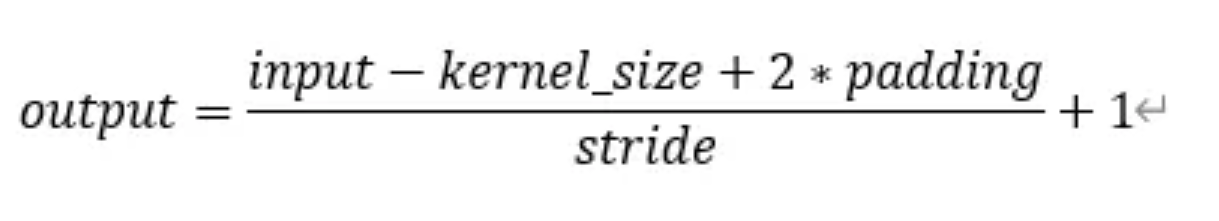
with an input of 13, a kernel size of 3, padding of 0, and a stride of 2, the output is 6. Since the feature maps and batch size remain unchanged, the output shape is (1, 256, 6, 6).

4.
- AlexNet has 61100840 parameters in total.
- 2469696 parameters are allocated for the "feature extraction" stage (23296 + 307392 + 663936 + 884992 + 590080).
- 58631144 parameters are allocated for the "classifier" stage (37752832 + 16781312 + 4097000).
- The feature extraction stage of a CNN has fewer parameters because of weight sharing in convolutional filters that detect universal image features. The classifier stage has more parameters due to fully connected layers where each neuron connects to all neurons in the previous layer.

Now we will visualize the weights of the neural network. For simplicity, we will visualize the first layer only.

torch.Size([64, 3, 11, 11])


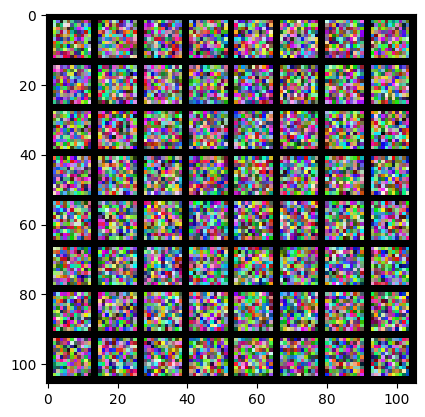

In [ ]:
from torchvision.utils import make_grid
kernels = alexnet.features[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)
img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

Lets load the pretrained weights and visualize both the first layer and

---

the second convoluational layer.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 108MB/s]


torch.Size([64, 3, 11, 11])


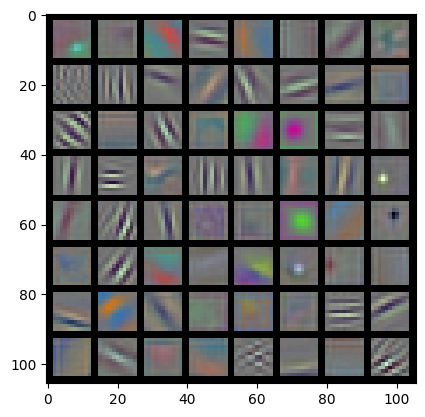

In [ ]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)
kernels = alexnet.features[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)

img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

torch.Size([64, 3, 5, 5])


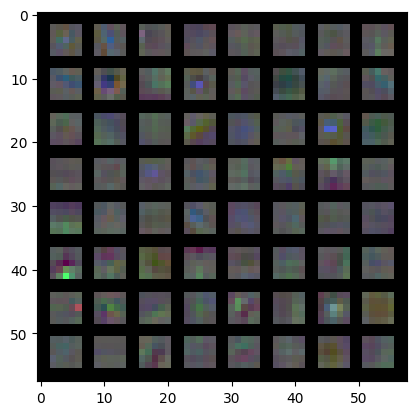

In [ ]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)
kernels = alexnet.features[3].weight.detach().clone()[:64,:3,:,:]
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)

img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

# Question:

1. Why and in what sense do the visualizations of the first layer look "better"?

# Answers:

1. The visualizations of the first layer filters look "better" because they are designed to capture basic, easily interpretable visual features, which are essential for image understanding and provide a strong starting point for the neural network to learn more complex representations in subsequent layers, in addition the first layer has a 11X11 compare to 5X5 in the second layer

# Part 2 - Training a CNN

You will train a convolutional neural network in PyTorch on the CIFAR10 dataset. Try using all the hyperparameters you can think: architectures, number of hidden layers, layer size, dropout, regularization, batch size, optimizer, loss functions and more. Good luck!

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 68889220.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


PyTorch expects images in the format (num_channels, width, height) while plt expects images in a numpy array of shape (width, height, num_channels). `np.transpose` takes as input an array and list of axes, and moves the original axes according to the order that appears in the list. For example, calling `transpose` with some image in the format (c,w,h) and the list (1,2,0) will return the array in the format (w,h,c).

Image shape:  torch.Size([3, 32, 32])
      frog       bird        dog      plane


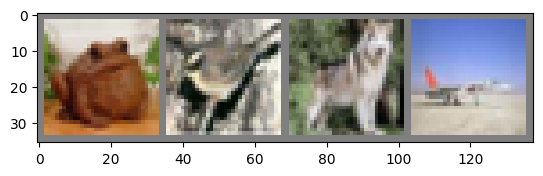

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Define the basic architecture of your network. You can use any combination#
        # of layers.                                                                #
        # In this function, you should only define the layers you intend to use.    #
        # Save each layer as a different *self variable*.                           #
        # This function has no return value.                                        #
        #############################################################################
        #First Convolutional layer
        #Input shape [3,32,32]
        #Output shape [32,32,32]
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(num_features = 32)
        self.relu1 = nn.ReLU()

        #2nd Convolutional layer
        #Input shape [32,32,32]
        #After pooling Output shape will be [32,16,16]
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(num_features = 32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #3rd Convolutional layer
        #Input shape [32,16,16]
        #Output shape [64,16,16]
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(num_features = 64)
        self.relu3 = nn.ReLU()

        #4th Convolutional layer
        #Input shape [64,16,16]
        #After pooling Output shape will be [64,8,8]
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(num_features = 64)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #5th Convolutional layer
        #Input shape [64,8,8]
        #Output shape [128,8,8]
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(num_features = 128)
        self.relu5 = nn.ReLU()

        #6th Convolutional layer
        #Input shape [128,8,8]
        #After pooling Output shape will be [128,4,4]
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn6 = nn.BatchNorm2d(num_features = 128)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #7th Convolutional layer
        #Input shape [128,4,4]
        #Output shape [256,4,4]
        self.conv7 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.bn7 = nn.BatchNorm2d(num_features = 256)
        self.relu7 = nn.ReLU()

        #8th Convolutional layer
        #Input shape [256,4,4]
        #After pooling Output shape will be [256,2,2]
        self.conv8 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.bn8 = nn.BatchNorm2d(num_features = 256)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #Flatten the last output
        self.flatten = nn.Flatten()

        #Creating 2 Fully connected layers, with relu activation and dropout regularization
        self.fc1 = nn.Linear(256 * 2 * 2, 1000)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1000, 10) #10 classes in CIFAR-10

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation of your network. Connect each layer to     #
        # the next and experiment with different activations, number of parameters  #
        # and depths. You can read about different activations in PyTorch at        #
        # https://pytorch.org/docs/stable/nn.html#non-linear-activation-functions   #
        # Return a single tensor after passing it through your network.             #
        # Hint: Shaping a multidimensional tensor into a vector can be achieved by: #
        # the method x.view()                                                       #
        #############################################################################
        #First Convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        #2nd Convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        #3rd Convolutional layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        #4th Convolutional layer
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        #5th Convolutional layer
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        #6th Convolutional layer
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        #7th Convolutional layer
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        #8th Convolutional layer
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)

        #Flatten the last output
        x = self.flatten(x)

        #2 Fc Layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)

        return x
net = Net()

#############################################################################
# TO DO:                                                                    #
# Pick a loss function and optimizer from your network. Start with a cross- #
# entropy loss and stochastic gradient descent with 0.001 learning rate and #
# test the effect of different learning rates and momentum.                 #
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0003)

In [ ]:
def train_network(net, critertion, optimizer, trainloader):
    net.train()
    #############################################################################
    # TO DO:                                                                    #
    # Train your network. Use the train loader to fetch a batch of data and     #
    # labels. Then, zero the parameter gradients by using optimizer.zero_grad() #
    # and perform a forward propagation and calculate the loss. Afterwards,     #
    # calculate the gradients and backprob using loss.backward(), and perform   #
    # the optimization step by using optimizer.step(). Use the provided         #
    # statistics function to print useful information during training.          #
    # Two iteration over the entire dataset (2 epochs) should be enough.        #
    # Print the loss every 2000 batches to babysit the learning process.        #
    #############################################################################
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            #Get the inputs from the dataloader
            inputs, labels = data

            #Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0


    print('Finished Training')

In [ ]:
import time
start_time = time.time()
train_network(net, criterion, optimizer, trainloader)
end_time = time.time()
training_duration = end_time - start_time
print(f"Training took {training_duration:.2f} seconds")

[1, 12500] loss: 8.781
[2, 12500] loss: 6.070
[3, 12500] loss: 4.913
[4, 12500] loss: 4.151
[5, 12500] loss: 3.481
Finished Training
Training took 5122.27 seconds


In [ ]:
dataiter = iter(testloader)

GroundTruth:      cat    ship    ship   plane
Predicted:        cat    ship    ship   plane


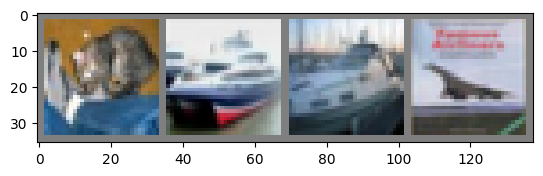

In [ ]:
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]]for j in range(4)))


In [ ]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 79.57%


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

# Part 3: More Visualizations

## Saliency Maps
A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

### PyTorch gather method
If `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,)` containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then `s.gather(1, y.view(-1, 1)).squeeze()` will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

In [ ]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print('s', s)
    print('y', y)
    print('gather', s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A trained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    saliency = None
    # Make input tensor require gradient (.requires_grad_()...)
    X.requires_grad_()

    # Perform a forward pass through the model to get the scores
    scores = model(X)

    # Select the scores corresponding to the correct class for each image
    # Hint: You will need to use the gather method
    cor_scores = scores.gather(1, y.view(-1, 1)).squeeze()

    # Perform a backward pass to compute gradients of the correct scores with respect to input images
    # Hint: during regular backprop, the value we start the backprop from is the value of the loss.
    #       Since we don't have a loss here, you can start from the value 1, for each score.
    cor_scores.backward(torch.ones_like(cor_scores))

    # Compute the saliency map as the maximum absolute value of gradients across the color channels
    saliency = X.grad.abs().max(dim=1)[0]

    return saliency

In [ ]:
def show_saliency_maps(X, y, model, classes):

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X, y, model)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].cpu().detach().mul_(torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)).add_(torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)).permute(1, 2, 0))
        plt.axis('off')
        plt.title(classes[labels[i]])

        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')

    plt.gcf().set_size_inches(12, 5)
    plt.show()


In [ ]:
dataiter = iter(testloader)

GroundTruth:      cat    ship    ship   plane


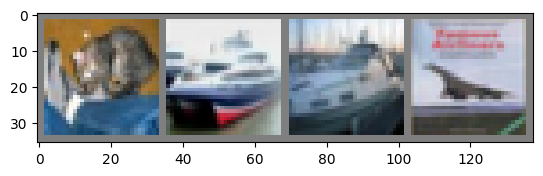

In [ ]:
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))

In [ ]:
images.shape

torch.Size([4, 3, 32, 32])

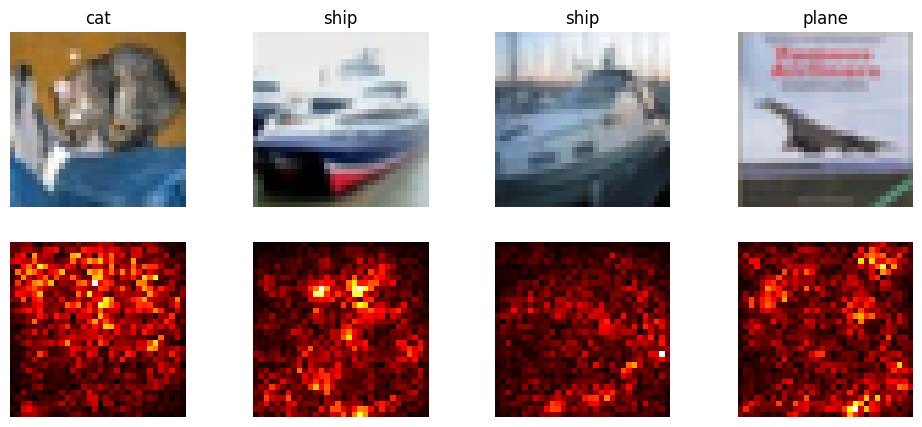

In [ ]:
show_saliency_maps(images, labels, net, classes)

The results might be better visualized if we take a proper pre-trained network, like alexnet, which has better accuracy on a much more complex data and even has higher resolution images.

In [ ]:
alexnet = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights)

In [38]:
#I had problem with uploading the imagenet_val_25.npz file so i connect to my Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    #Uploading the file from my Google Drive
    imagenet_fn = '/content/drive/My Drive/imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names
images, labels, class_names = load_imagenet_val(num=5)

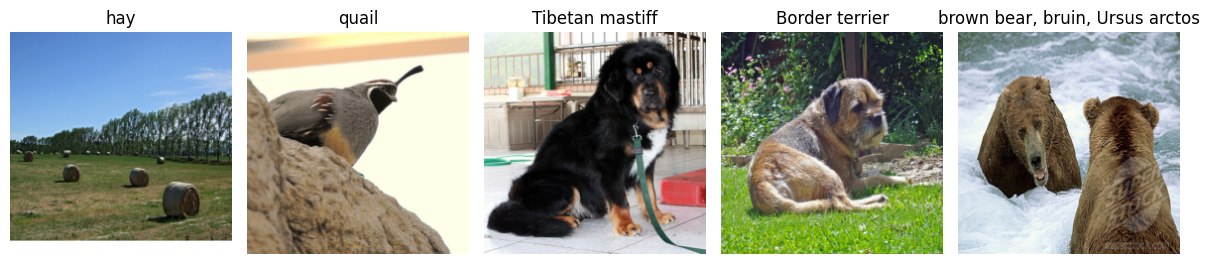

In [42]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [43]:
ALEXNET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
ALEXNET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [44]:
def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=ALEXNET_MEAN.tolist(),
                    std=ALEXNET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(img)

In [45]:
images_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in images], dim=0)
labels_tensor = torch.LongTensor(labels)

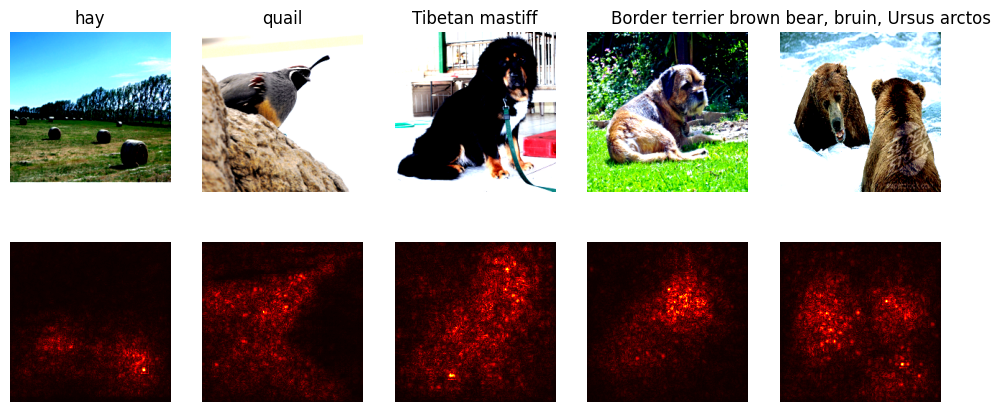

In [46]:
show_saliency_maps(images_tensor, labels_tensor, alexnet, class_names)